# World Data League 2023

## 🎯 Challenge
###Energy communities inclusive of residents vulnerable to energy poverty


## Team: CEOS
## 👥 Authors
* Ana Maria Sousa
* Duarte Rodrigues
* Mariana Sousa
* Mariana Xavier
* Ricardo Brioso

## 💻 Development

The world faces a severe energy crisis, with an urgent need to conserve energy and switch to renewables. With this global crisis comes what is defined as "energy poverty" - i.e. an increasing difficulty observed in residents to afford the energy to live. The city of Ghent is no stranger to these problems as they have huge ambitions in the fields of energy efficiency and sustainability. The city has mapped the solar potential of solar roofs and our goal is to leverage the existing data to propose how energy communities can be formed within the city, mitigating the two presented problems.

To achieve that, we were provided with various datasets:
* Geographical data on sun irradiation on a 3D model of Ghent;
* Three datasets on energy consumption;
* Four datasets on energy production, storage devices and EV charging points;
* One dataset on average income per sector;
* One dataset on current rent prices in different locations.











### Imports and requirements

In [ ]:
# Requirements

!pip install geopandas contextily unidecode pyclustering termcolor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.5 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=fae24447be753b6411df30b5e6d8232fb2845c0045bded9f6698e1ace779fafe
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclust

In [ ]:
# Imports

import os
import re
import ast
import math
import torch
import random
import warnings
import datetime
import matplotlib.cbook
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as patches
from termcolor import colored
from google.colab import drive
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from pyclustering.cluster.kmeans import kmeans
from shapely.geometry import MultiPolygon, Polygon
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

<ipython-input-2-2366946e3418>:33: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)


In [ ]:
# Mount google drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Functions

In [ ]:
def district_postalcode_ass(data_path):
    ''' Function that allows to associate postalcode to each district/sector. '''

    # Assocation of each sector to the respective district
    district_names= pd.read_excel(os.path.join(data_path, 'others', 'sectoren_district.xlsx'))

    # List of postalcode for each district
    post_code={
        'Binnenstad':9000,
        'Biomekenswijk': 9040,
        'Brugse Poort - Rooigem': 9000,
        'Dampoort': 9000,
        'Drongen': 9031,
        'Elisabethbegijnhof - Prinsenhof - Papegaai - Sint-Michiels':9000,
        'Gentbrugge': 9050,
        'Gentse Kanaaldorpen en -zone':9042,
        'Ledeberg':9050,
        'Macharius - Heirnis': 9000,
        'Mariakerke': 9030,
        'Moscou - Vogelhoek': 9000,
        'Muide - Meulestede - Afrikalaan':9000,
        'Nieuw Gent - UZ':9000,
        'Oostakker': 9041,
        'Oud Gentbrugge': 9050,
        'Rabot - Blaisantvest': 9000,
        'Sint-Amandsberg': 9040,
        'Sint-Denijs-Westrem - Afsnee': 9051,
        'Sluizeken - Tolhuis - Ham': 9000,
        'Stationsbuurt-Noord': 9000,
        'Stationsbuurt-Zuid': 9000,
        'Watersportbaan - Ekkergem': 9000,
        'Wondelgem': 9032,
        'Zwijnaarde': 9052}

    # Creation of dataframe of postalcode <=> district
    district_post_code = pd.DataFrame.from_dict(post_code, orient='index', columns=['PostalCode'])
    district_post_code  = district_post_code.reset_index().rename(columns={'index': 'District'})

    # Associate district names, based on sectoren names
    sectoren_list=[]
    for d_name in district_names.keys():
        d=district_names.copy()
        d.dropna(subset=[d_name], inplace=True)
        sectoren_list.append(d[d_name].tolist())

    # Creation of dataframe of sectoren <=> district
    Sectoren_district=pd.DataFrame({'District': district_names.keys().tolist(),'Sectoren': sectoren_list })
    Sectoren_district=Sectoren_district.explode('Sectoren')

    return Sectoren_district, district_post_code

def mean_ignore_zeros(group):
    ''' Calculate the mean of a group ignoring the 0 values. '''
    return group[group != 0].mean()

def std_ignore_zeros(group):
    ''' Calculate the std of a group ignoring the 0 values. '''
    return group[group != 0].std()

def pre_processing_income(data_path):
  ''' Function to preprocess average income dataset. '''

  Sectoren_district, district_post_code = district_postalcode_ass(data_path)

  # Combine dataframe to obtained DataFrame with district and sectoren information
  df_avg_income_dist=pd.merge(df_avg_income, Sectoren_district, on='Sectoren')
  df_avg_income_dist=pd.merge(df_avg_income_dist, district_post_code  , on='District')

  # Assumed zero in case of missing values
  df_avg_income_dist.replace('x', 0, inplace=True)
  df_avg_income_dist.replace(np.nan, 0, inplace=True)

  avg_income_dist = df_avg_income_dist.iloc[:, 1:-2].astype(int)
  avg_income_dist['District'] = df_avg_income_dist['District']
  avg_income_dist['PostalCode'] = df_avg_income_dist['PostalCode']

  # calculate mean and std within postalcode ignoring income 0 since those were missing values
  mean_income_values = avg_income_dist.groupby('PostalCode').apply(mean_ignore_zeros)
  std_income_values = avg_income_dist.groupby('PostalCode').apply(std_ignore_zeros)

  mean_income_values['PostalCode'] = avg_income_dist['PostalCode']
  mean_income_values['PostalCode'] = mean_income_values.index
  mean_income_values=mean_income_values.drop(9042, axis=0) # remove 9042 since is not part of Ghent

  std_income_values['PostalCode'] = avg_income_dist['PostalCode']
  std_income_values['PostalCode'] = std_income_values.index
  std_income_values=std_income_values.drop(9042, axis=0) # remove 9042 since is not part of Ghent

  # Change collumns values
  columns_names=mean_income_values.columns.tolist()
  years=[]
  for name in columns_names:
    numbers = re.findall(r'\d+', name)
    if(len(numbers)>0):
      years.append(numbers[0])

  mean_income_values = mean_income_values.rename(columns=dict(zip(mean_income_values.columns[:], years)))
  std_income_values = std_income_values.rename(columns=dict(zip(std_income_values.columns[:], years)))

  return  mean_income_values, std_income_values

In [ ]:
def pre_process_ev_points(csv_path, type='nparray', municipality_post_code=[9000, 9052]):
  ''' Function to read preprocess EV charging points dataset. '''

  # Load and rename columns
  ev_points_col_names = {'Jaartal indienstname': 'Commissioning Year',
                       'Postcode': 'Postal Code',
                       'Vermogen (kVA)': 'Power (kVA)' ,
                       'Spanningsniveau aansluiting': 'Voltage Level Connection',
                       'Postcode (hiërarchisch)': 'Postal Code (hierarchical)',
                       'Uniek_order_ID': 'Unique Order ID',
                       'geom': 'geom',
                       'centroid': 'centroid',
                       'Postcode Numeriek': 'Zip Code Numeric'}
  data = pd.read_csv(csv_path, on_bad_lines='skip', sep=';')
  data = data.rename(columns=ev_points_col_names)

  # Filter the data based on the postal codes
  if municipality_post_code is not None:
    data = data[(data['Postal Code'] >= municipality_post_code[0]) & (data['Postal Code'] <= municipality_post_code[1])]

  # Create a GeoDataFrame from the CSV data
  data['coordinates'] = data['geom'].apply(lambda x: ast.literal_eval(x)['coordinates'])

  if municipality_post_code is None:
    data.drop(index=[1664, 1672], inplace=True)

  if type == 'nparray':
    data['coordinates'] = data['coordinates'].apply(lambda x: np.array(x)[0, 0, :, :])
  elif type == 'polygon':
    data['coordinates'] = data['coordinates'].apply(lambda x: Polygon(np.array(x)[0, 0, :, :]))

  # Get latitude and longitude
  data['centroid_lat'] = data['centroid'].apply(lambda x: x.split(',')[0])
  data['centroid_lon'] = data['centroid'].apply(lambda x: x.split(',')[1])

  return data

def visualize_points(gdf, feature, lon='centroid_lon', lat='centroid_lat'):
  ''' Function to create figure plotting a feature on the corresponding longitude/latitude on map. '''

  fig = go.Figure()

  fig.add_trace(go.Scattermapbox(
      mode='markers',
      lon=gdf[lon],
      lat=gdf[lat],
      marker=dict(
          size=8,
          color=gdf[feature],
          colorscale='Viridis',
          cmin=gdf[feature].min(),
          cmax=gdf[feature].max(),
          opacity=0.7,
          colorbar=dict(title=feature)
      )
  ))

  fig.update_layout(
      mapbox=dict(
          style='open-street-map',
          zoom=12,
          center=dict(lat=51.0500, lon=3.7303)
      ),
      showlegend=False
  )

  fig.show()

In [ ]:
def preprocess_energy_consumption_sector(sector_data):
  ''' Preprocess energy consumption per sector dataset. '''

  # Renaming the columns from ductch to english
  sector_data.rename(columns={'Verbruiksjaar': 'Year', 'Markt': 'Type', 'Richting': 'Injection/Outtake',
                              'Statistische Sector': 'CityCodeSector', 'Provincie': 'Province',
                              'Gemeente': 'Municipality', 'Rol Contact': 'Personal/Company',
                              'Aantal': 'NumAccessPoints', 'Benaderend Verbruik (kWh)': 'AccessPoints*Consumption (kWh)'},
                     inplace=True)
  sector_data.drop(sector_data[sector_data['Municipality'].str.upper() != 'GENT'].index, inplace=True) # filtering to study only the Gent city
  sector_data.sort_values('Year', inplace=True) # organized the data by year
  sector_data.reset_index(drop=True, inplace=True)

  return sector_data

def preprocess_energy_consumption_month(month_data):
  ''' Preprocess energy consumption per month dataset. '''

  # This dataset divides the entries by a certain code, that describes the profile of energy consumption. However in gent only these 9 codes are valid
  valid_codes = ['S21','S22','S11','S12','S18','S19','S41','S31','S32']

  # Renaming the columns from ductch to english
  month_data.rename(columns={'Hoofdgemeente': 'Municipality', 'Energie': 'TypeEnergy',
                             'SLP': 'UserProfileCode','202109':'2021-09', '202108':'2021-08',
                             '202107':'2021-07', '202106':'2021-06', '202105':'2021-05',
                             '202104':'2021-04', '202103':'2021-03', '202102':'2021-02',
                             '202101':'2021-01', '202012':'2020-12', '202011':'2020-11',
                             '202010':'2020-10', '202009':'2020-09'},
                    inplace=True)
  month_data.drop(month_data[month_data['Municipality'].str.upper() != 'GENT'].index, inplace=True)# filtering to study only the Gent city
  month_data.drop(month_data[np.logical_not(month_data['UserProfileCode'].isin(valid_codes))].index, inplace=True) # filtering to study only the valid codes

  # For legend purposes, the codes were described as shown in the city website (present in the data dictionary)
  month_data['UserProfileCode'].replace('S21', 'Eletricity Household Night-Day ratio < 1.3', inplace=True)
  month_data['UserProfileCode'].replace('S22', 'Eletricity Household Night-Day ratio >= 1.3', inplace=True)
  month_data['UserProfileCode'].replace('S11', 'Eletricity Non-Household capacity < 56 kVA', inplace=True)
  month_data['UserProfileCode'].replace('S12', 'Eletricity Non-Household capacity >= 56 kVA', inplace=True)
  month_data['UserProfileCode'].replace('S18', 'Eletricity Apartment Consumer', inplace=True)
  month_data['UserProfileCode'].replace('S19', 'Eletricity Public Lighting', inplace=True)
  month_data['UserProfileCode'].replace('S41', 'Domestic natural gas', inplace=True)
  month_data['UserProfileCode'].replace('S31', 'Professional natural gas Consumption < 150,000 kWh', inplace=True)
  month_data['UserProfileCode'].replace('S32', 'Professional natural gas Consumption >= 150,000 kWh', inplace=True)
  month_data.reset_index(drop=True, inplace=True)

  return month_data

def preprocess_energy_consumption_streetEDA(street_data):
  ''' Preprocess the energy consumption per street for EDA purposes. '''
  # Renaming the columns from ductch to english
  street_data.rename(columns={'Verbruiksjaar': 'Year', 'Richting': 'Injection/Outtake',
                              'Hoofdgemeente': 'Municipality', 'Straat': 'street_name',
                              'Benaderend verbruik (kWh)': 'Energy Consumption (kWh)',
                              'Aantal Toegangspunten': 'Access Points', 'Regio':'Region',
                              'Energie':'Energy'},
                     inplace=True)
  street_data.drop(street_data[street_data['Municipality'].str.upper() != 'GENT'].index, inplace=True)# filtering to study only the Gent city

  # This dataset has information on various years, however 2021, the most recent, is the one with ma higher number of unique streets.
  # So filtered to use only this year, as it would not be correct to average some streets and other not.
  street_data.drop(street_data[street_data['Year'] != 2021].index, inplace=True)
  street_data.drop(street_data[street_data['Injection/Outtake'] == 'Injectie'].index, inplace=True)# filtering to study only the consumption and not injection
  street_data.dropna(subset=['street_name'], inplace=True) # remove NaN
  street_data.sort_values('street_name', inplace=True) # sort by street name
  street_data.reset_index(drop=True, inplace=True)

  return street_data

def preprocess_energy_consumption_street_merge(street_data):
  ''' Further peprocess the energy consumption per street for data merge purposes. '''

  # Not only we want to study the consumption in the model, but only of eletricity because that is the direct replacement of energy produced by solar panels
  street_data.drop(street_data[street_data['Energy'] == 'Aardgas'].index, inplace=True) # filtering to study only the eletricity
  street_data.reset_index(drop=True, inplace=True)

  return street_data

In [ ]:
def preprocess_energy_storage(data_ESS):
  ''' Function to preprocess energy storage systems dataset. '''

  # Rename columns
  rename_columns = ['Online placement date', 'Online placement Year', 'Online placement month',
                    'Type of technology', 'Capacity (kWh)', 'Power inverter (kVA)',
                    'Voltage level', 'Internal ID']
  data_ESS.columns= rename_columns

  # Drop column of type of technology because all records have the same value - insignificant attribute
  # Drop internal ID as it is also irrelevant
  data_ESS=data_ESS.drop(columns=['Type of technology', 'Internal ID', 'Power inverter (kVA)'])

  # Convert 'Online placement date' column type to datetime
  data_ESS['Online placement date'] = pd.to_datetime(data_ESS['Online placement date'])

  # Drop rows without values
  data_ESS = data_ESS.dropna(how='any')

  return data_ESS

def preprocess_energy_local_prod(data_loc_p):
  ''' Function to preprocess energy local production dataset. '''

  # Rename columns
  rename_columns = ['Reference date', 'DNB', 'Main municipality', 'Type of technology',
                    'Number of local production', 'Installed power']
  data_loc_p.columns= rename_columns

  # Change the Dtype to a datetime of the column 'Reference date'
  data_loc_p['Reference date']=pd.to_datetime(data_loc_p['Reference date'])

  # Filter the registers by the main municipality of GENT to analyze in more detail the municipality that was chosen as the target.
  filter = data_loc_p['Main municipality'] == 'GENT'
  data_gent = data_loc_p[filter].reset_index()

  return data_gent

def preprocess_energy_decentral_prod(data_dec_p, municipality_post_code=[9000, 9052]):
  ''' Function to preprocess energy decentral production dataset. '''

  # Rename columns
  rename_columns = [ 'Year of commissioning','Type of technology','Power (kVA)','Voltage level','Municipality of Nis Code','Postal code','Postal code (hierarchical)','Internal ID']
  data_dec_p.columns= rename_columns

  # Filter by the postal code of GENT (between of 9000 and 9052 )
  filter = (data_dec_p['Municipality of Nis Code'] == 44021)
  data_gent_dec_P = data_dec_p[filter]

  # Drop NaN values
  data_gent_dec_P = data_gent_dec_P.dropna()

  # Convert the column 'Year of commissioning' for a datetime column containing only the year
  data_gent_dec_P['Year of commissioning']  = data_gent_dec_P['Year of commissioning'].apply(lambda x: datetime.datetime(int(x), 1, 1))

  # Convert postal code column to int
  data_gent_dec_P['Postal code']  = data_gent_dec_P['Postal code'].apply(lambda x: int(x))

  # Drop not needed features
  data_gent_dec_P_final = data_gent_dec_P.drop(columns=['Internal ID', 'Type of technology', 'Municipality of Nis Code', 'Postal code (hierarchical)'])

  # Create a table with the attributes 'Voltage level', 'Postal code', 'Year of commissioning'
  # and the mean of the power (KVA).
  data_gent_dec_P_final = data_gent_dec_P_final.groupby(['Voltage level','Postal code','Year of commissioning']).agg(mean=('Power (kVA)', 'mean')).reset_index()

  # Filter by Ghent postal codes
  data_gent_dec_P_final = data_gent_dec_P_final[(data_gent_dec_P_final['Postal code'] >= municipality_post_code[0]) & (data_gent_dec_P_final['Postal code'] <= municipality_post_code[1])]

  return data_gent_dec_P_final

In [ ]:
def preprocess_gent_sol(gent_sol):
  '''
  Function to preprocess the Ghent Solar Load Output dataset: renaming columns
  for better understanding and ensuring that all data entries are from the Ghent
  municipality, thus eliminating null values.
  '''

  # Rename data keys
  gent_sol_renamed = gent_sol.rename(columns={'GRB_UIDN': 'building_id', 'GRB_OIDN': 'object_id',
                              'ENTITEIT': 'building_type', 'TYPE': 'building_type_encoded', 'LBLTYPE': 'building_category',
                              'DATUM_GRB': 'date_creation', 'DATUM_LID': 'date_mapping',
                              'OPPERVL': 'building_surface_area', 'LENGTE': 'building_length',
                              'STRAATNMID': 'streed_id', 'STRAATNM': 'street_name',
                              'NISCODE': 'NIS_code', 'GEMEENTE': 'municipality', 'POSTCODE': 'postal_code',
                              'HNRLABEL': 'building_number',
                              'SLOPE': 'roof_slope', 'ASPECT': 'roof_orientation',
                              'IRR_SqM': 'ASI_sqm (W/m^2)', 'IRR_Tot': 'ASI_total (W/m^2)',  # ASR - Annual Solar Irradiation
                              'Type_Dak': 'roof_type',
                              'Opwek_E': 'EEP (kWh)'})  # EEP - Estimated Energy Produced (by a solar installation or system)

  gent_sol_renamed['street_name'] = gent_sol_renamed['street_name'].str.upper()
  gent_sol_renamed['street_name'] = gent_sol_renamed['street_name'].apply(lambda x: unidecode(x) if pd.notna(x) else x)

  # Ensure that all data entries are from Gent municipality
  filtered_data = gent_sol_renamed[(gent_sol_renamed['NIS_code']=='44021') & (gent_sol_renamed['municipality']=='Gent')]
  filtered_data = filtered_data.drop(columns={'NIS_code', 'municipality'})
  filtered_data = filtered_data.reset_index(drop=True)

  return filtered_data

In [ ]:
def encode_features(collumn_str, df):
  ''' Label encoder for column it receives as input. '''

  # Create an instance of LabelEncoder
  label_encoder = LabelEncoder()

  # Fit the LabelEncoder to the column and transform the values
  encoded_values = label_encoder.fit_transform(df[collumn_str])

  # Replace the original column with the encoded values
  model_data[collumn_str] = encoded_values

  # Get the unique labels and their corresponding encoded values
  labels = label_encoder.classes_
  encoded_dict = dict(zip(labels, encoded_values))

  return df, encoded_dict

In [ ]:
def custom_distance(point1, point2, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight, alpha=0.5):
    """
    Custom score function to optimize the point distribution and clustering, based on the social features of a city.
    A lower score between 2 points indicates that this should in the same cluster."""

    # Euclidean distance of the coordinates of the 2 points - higher distance > higher score > houses should not be on the same cluster
    geographic_distance = (np.linalg.norm(point1[:2] - point2[:2])**2)*geo_weight

    # As the objective is to motivate social and energy mix, the higher the diversity the lower must be the score
    # To account for that we applied the exp^-alpha to the distance between 2 points, creating an inverse effect.
    # This solution is good because certain features when subtracted can be 0, for example if 2 houses are in the same postal code for the rent

    rent_diversity = math.exp(-alpha * (point1[17] - point2[17])**2) * rent_diversity_weight
    income_diversity = math.exp(-alpha * (point1[20] - point2[20])**2) * income_diversity_weight
    EEP_diversity = math.exp(-alpha * (point1[13] - point2[13])**2) * EEP_diversity_weight
    consumption_diversity = math.exp(-alpha * (point1[19] - point2[19])**2) * consumption_diversity_weight
    production_diversity = math.exp(-alpha * (point1[18] - point2[18])**2) * production_diversity_weight

    score = geographic_distance+rent_diversity+income_diversity+EEP_diversity+consumption_diversity+production_diversity

    # Based on the calculations, here the spare energy of both buildings is being summed to see if it is above than the correspondent normalized threshold of 0 kWh
    if point1[22]+point2[22] > spare_thr_norm:
      score= score - spare_reward_weight*score # having spare energy that can be shared is good, so the score decreases by a certain weight (reward system)

    return score

def calculate_wcss(data, clusters, centers, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight):
    """
    This function calculates the within-cluster sum of squares (WCSS).
    WCSS is a measure of compactness of the clusters, where smaller values
    indicate that the data points are closer to their respective centroids.
    """

    wcss = 0.0  # Initialize the WCSS to 0.

    # Loop over each cluster and its index.
    for cluster_index, cluster in enumerate(clusters):
        # Get the center of the current cluster.
        cluster_center = centers[cluster_index]

        # Loop over each data point index in the current cluster.
        for point_index in cluster:
            # Get the actual data point using the index.
            point = data[point_index]

            # Compute the custom score between the data point and the cluster center.
            distance= custom_distance(point, cluster_center, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight)

            # Add the square of the distance to the WCSS.
            wcss += distance ** 2

    # Return the computed WCSS.
    return wcss

def model_k_optimization(kmin, kmax, model_data_normalized, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight):
    """
    This function performs k-means clustering for a range of values of k (number of clusters)
    and calculates the within-cluster sum of squares (WCSS) for each value of k. This helps in
    identifying the optimal number of clusters using the Elbow Method.
    """

    # Determine the range of k values based on the given kmin and kmax
    if kmin > 1:
        k_values = range(kmin, kmax, 5)
    else:
        k_values = range(2, kmax, 5)

    wcss = []  # List to hold the WCSS values for each k

    # Perform k-means clustering for each value of k
    for k in k_values:
        # Create a custom distance metric object
        user_function = lambda point1, point2: custom_distance(point1 , point2, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight)
        metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

        # Perform k-means clustering using kmeans_plusplus for initialization
        start_centers = kmeans_plusplus_initializer(model_data_normalized, k).initialize()
        kmeans_instance = kmeans(model_data_normalized, initial_centers=start_centers, metric=metric)
        kmeans_instance.process()

        # Calculate the WCSS for the current clustering
        clusters = kmeans_instance.get_clusters()
        centers = kmeans_instance.get_centers()
        wcss_value = calculate_wcss(model_data_normalized, clusters, centers, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight)
        wcss.append(wcss_value)

    # Plot the WCSS for each value of k
    plt.plot(k_values, wcss, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method')
    plt.show()

    Ideal_K = k_values[wcss.index(min(wcss))]
    print('The ideal K is ' + str(Ideal_K))
    return Ideal_K

In [ ]:
def cluster_info_explained(model_data, result):
  """ After clustering, we can extract various kinds of information about each community. Here, we present a plot with an energy balance."""

  # Merging the clustering results with the initial features
  df_result = result.merge(model_data.loc[:, ['EletrictyConsumption', 'EEP (kWh)']], left_index=True, right_index=True)
  counts = df_result.groupby('Community').size().reset_index(name='Count')
  df_result = df_result.merge(counts)
  df_result=df_result.drop('House', axis=1)

  # Calculate the mean of each attribute per cluster - Energy consumption and production per house
  mean_df = df_result.groupby('Community').mean()
  counts = df_result.groupby('Community').size().reset_index(name='Count')

  # Renaming for legend purposes
  mean_df.rename(columns={'Count': 'Number of houses'}, inplace=True)
  mean_df.rename(columns={'EletrictyConsumption': 'Eletricity consumption'}, inplace=True)
  mean_df.rename(columns={'EEP (kWh)': 'Solar Energy Potential production'}, inplace=True)

  # Get the attribute names
  attribute_names = mean_df.columns

  # Get the number of clusters
  k = len(mean_df)

  # Set the width of the bars
  bar_width = 0.2

  # Set the positions of the bars on the x-axis
  bar_positions = np.arange(k)

  # Create the barplot
  fig, ax = plt.subplots(figsize=(10, 10))

  for i, attribute in enumerate(attribute_names):
      # Calculate the x position for each bar
      x = bar_positions + (i * bar_width)

      # Get the mean values for the current attribute
      y = mean_df[attribute]

      # Plot the bars
      ax.bar(x, y ,width=bar_width, label=attribute)

  # Add labels, title, and legend
  ax.set_xlabel('Cluster')
  ax.set_ylabel('Mean Values')
  ax.set_title('Mean Values of Attributes per Cluster')
  ax.set_xticks(bar_positions + (bar_width * (len(attribute_names) - 1)) / 2)
  ax.set_xticklabels(range(1, k+1))
  ax.legend()

  # Show the barplot
  plt.show()

### EDA - data quality and analysis

In [ ]:
data_path = '/content/drive/My Drive/WDL/Finals/Data'

####Average Income

Through income data, the monetary capabilities of people in society from different regions of Ghent can be analyzed.

In [ ]:
# Load and preprocess income data
df_avg_income = pd.read_csv(os.path.join(data_path, 'average_income_per_sector.csv'), sep=';')

mean_income_values, std_income_values = pre_processing_income(data_path)
mean_income_values_lines = mean_income_values.drop(['PostalCode'], axis=1).T
std_income_values_lines = std_income_values.drop(['PostalCode'], axis=1).T

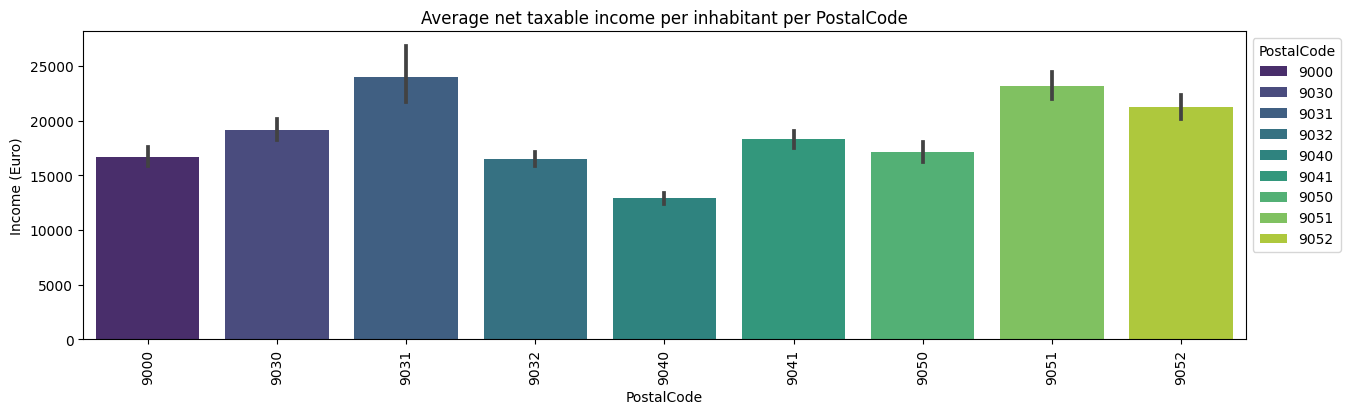

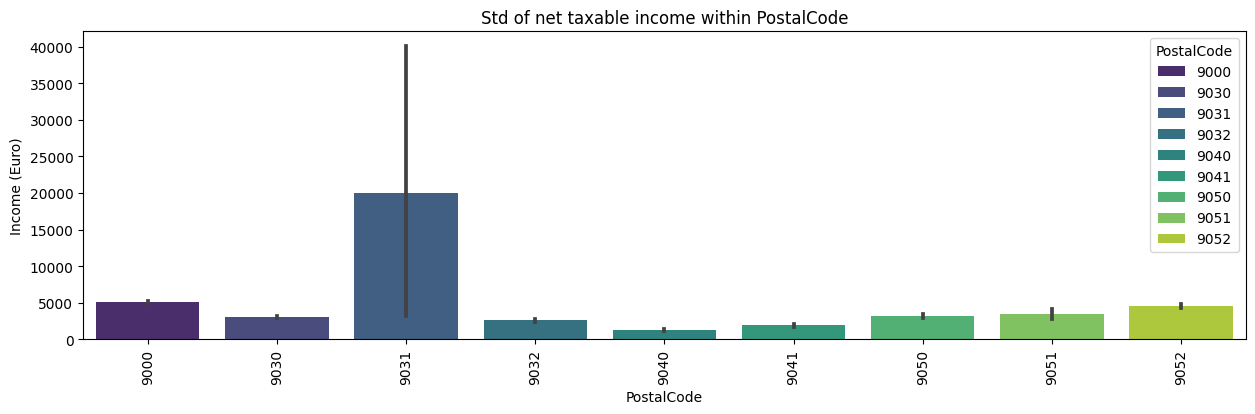

In [ ]:
# Plot average income per postal code
plt.figure(figsize=(15, 4))
sns.barplot(data=mean_income_values_lines, palette='viridis', label=mean_income_values['PostalCode'])
plt.title('Average net taxable income per inhabitant per PostalCode')
plt.ylabel('Income (Euro)')
plt.legend(title='PostalCode', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

# Plot std of income per postal code
plt.figure(figsize=(15, 4))
sns.barplot(data=std_income_values_lines, palette='viridis', label=std_income_values['PostalCode'])
plt.title('Std of net taxable income within PostalCode')
plt.ylabel('Income (Euro)')
plt.legend(title='PostalCode', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

From the 'Average Net Taxable Income Per Person by Postal Code' bar charts, we find that certain areas are characterized by higher incomes, such as 9031 and 9051, while others like 9040 show a clear disadvantage. These differences have remained more or less constant over the years, with only small variations for all postal codes.

In addition, the standard deviation values within each postal code allow us to visualize if there are regions with great social inequalities in terms of income. The 'Std of net taxable income within PostalCode' barplot allows us to identify a major social discrepancy at 9031, which also changed a lot over time.

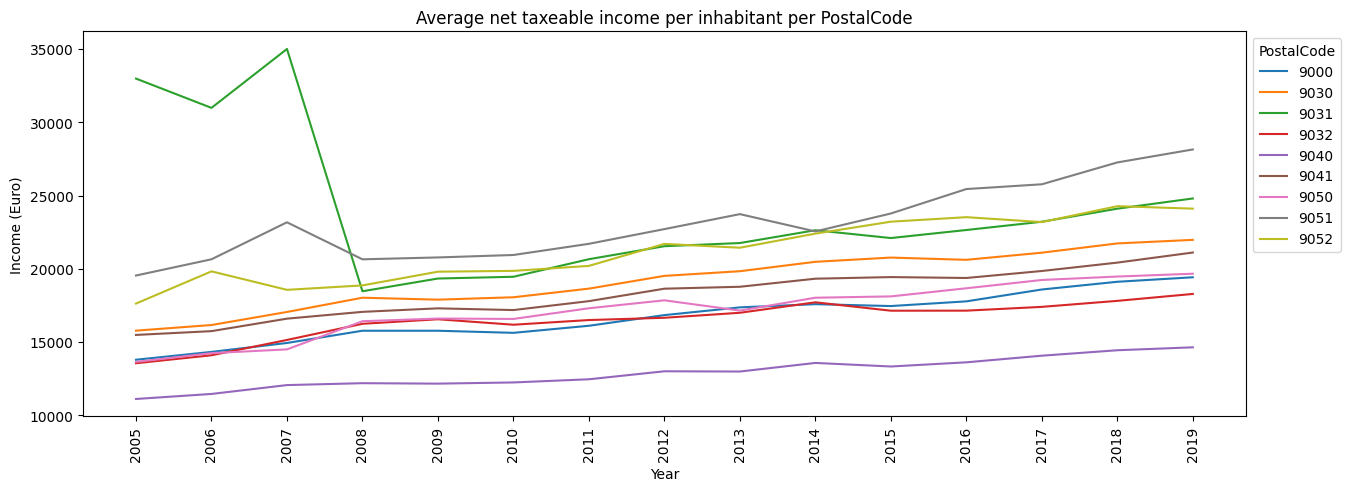

In [ ]:
# Plot average income over the years per postal code
plt.figure(figsize=(15, 5))
for c in mean_income_values_lines.columns:
  sns.lineplot( data=mean_income_values_lines[c], label=mean_income_values['PostalCode'][c])
plt.title('Average net taxeable income per inhabitant per PostalCode')
plt.xlabel('Year')
plt.ylabel('Income (Euro)')
plt.legend(title='PostalCode', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()

Concluding the analysis of the income per inhabitant, we see that all regions follow a similar trend of increasing income, through the previous graph. Nevertheless, this does not mean a direct increase in economic power since for that we also need to consider living costs, rents, inflation etc.

####EV Charging Points

Through EV charging points, it is possible to see where they are placed and where their need is noted.

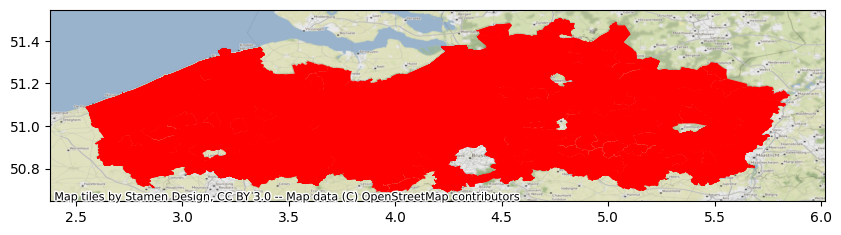

In [ ]:
# Read the EV charging points data from CSV
ev_points_file_path = os.path.join(data_path, 'ev_points.csv')

# Preprocess
ev_points = pre_process_ev_points(ev_points_file_path, type='polygon', municipality_post_code=None)

ev_points = gpd.GeoDataFrame(ev_points, geometry='coordinates')
ev_points = ev_points.set_geometry('coordinates')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the charging points
ev_points.plot(ax=ax, color='red', markersize=0.5)

# Add OpenStreetMap background
ctx.add_basemap(ax, crs='EPSG:4326')

# Show the plot
plt.show()

In [ ]:
visualize_points(ev_points, 'Power (kVA)', lon='centroid_lon', lat='centroid_lat')
visualize_points(ev_points, 'Commissioning Year', lon='centroid_lon', lat='centroid_lat')

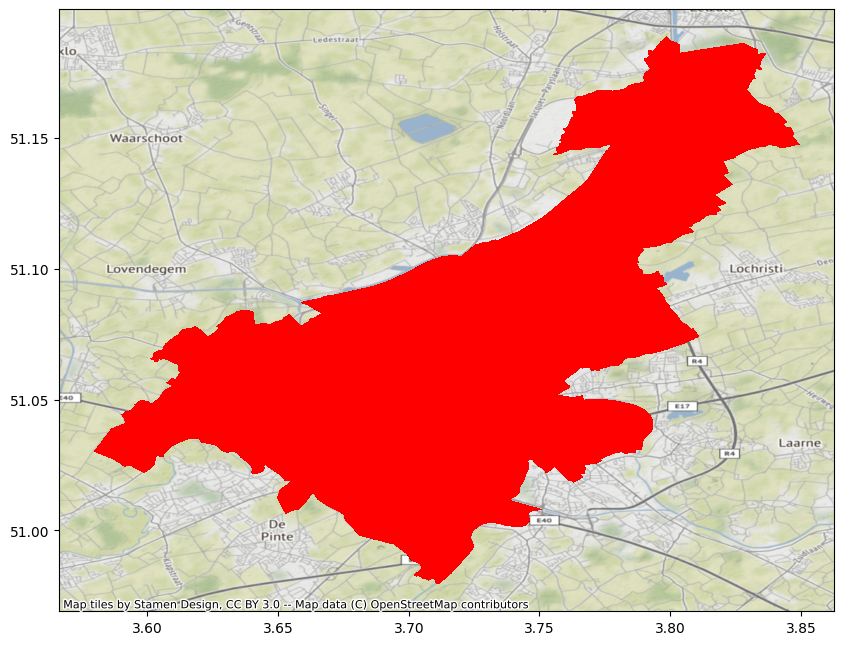

In [ ]:
ev_points = pre_process_ev_points(ev_points_file_path, type='polygon')

ev_points = gpd.GeoDataFrame(ev_points, geometry='coordinates')
ev_points = ev_points.set_geometry('coordinates')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the charging points
ev_points.plot(ax=ax, color='red', markersize=0.5)

# Add OpenStreetMap background
ctx.add_basemap(ax, crs='EPSG:4326')

# Show the plot
plt.show()

The map above represents the shape of the district of Gent and all of Electric Vehicle Charging Points. The dataset contains several EV points in the district of Gent but all of these points have the same multipolygon shape and the same centroid, because of this is not possible to plot them individually. There is the street name of the EV charging point that could possibily be overlaped with other datasets.

Number of EV charging points: 187
Average Power of the charging points: 24.9
Standard Deviation of the charging points: 15.9
Average Comissioning Year of the charging points: 2018.9
Standard Deviation Comissioning Year of the charging points: 1.6


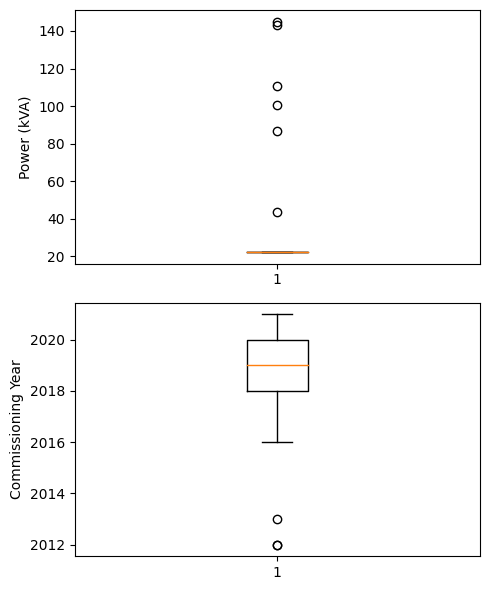

In [ ]:
# Calculate the average and standard deviation
avg_power = ev_points['Power (kVA)'].mean()
std_power = ev_points['Power (kVA)'].std()

avg_year = ev_points['Commissioning Year'].mean()
std_year = ev_points['Commissioning Year'].std()

ev_points_count = ev_points['Power (kVA)'].count()
print(f'Number of EV charging points: {ev_points_count}')

print(f'Average Power of the charging points: {np.round(avg_power,1)}')
print(f'Standard Deviation of the charging points: {np.round(std_power,1)}')

print(f'Average Comissioning Year of the charging points: {np.round(avg_year,1)}')
print(f'Standard Deviation Comissioning Year of the charging points: {np.round(std_year,1)}')

# Create a new figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Whisker plot for average power
ax1.boxplot(ev_points['Power (kVA)'])
ax1.set_ylabel('Power (kVA)')

# Whisker plot for average year
ax2.boxplot(ev_points['Commissioning Year'])
ax2.set_ylabel('Commissioning Year')

plt.tight_layout()
plt.show()

The boxplots above, shows that the average power of the EV charging points is 25 kVA and the average commissioning year is 2019. There are some points with a very high power that might have some specific purpose.

####Energy Consumption per Sector

The energy consumption per sector constitutes important information to understand the consumption trends per economic sector such as industry, and transportation, among others.

In [ ]:
# Load and preprocess data
path_sector = os.path.join(data_path, 'energy_consumption_sectors.csv')
sector_data = pd.read_csv(path_sector, sep=';')
sector_data = preprocess_energy_consumption_sector(sector_data)

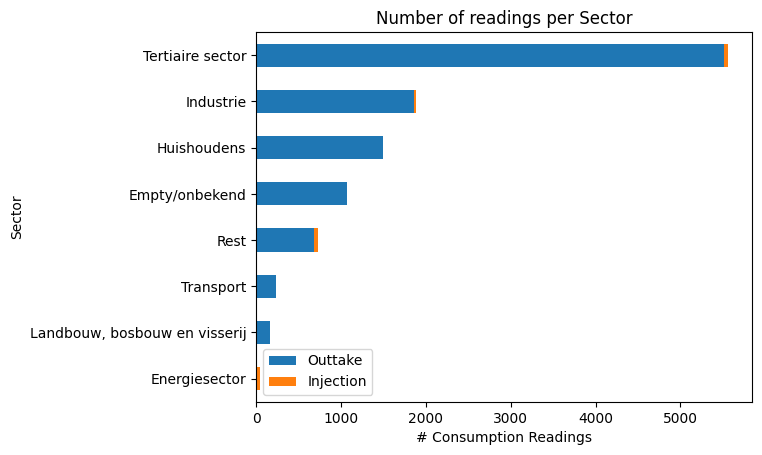

In [ ]:
# Plot the number of data entries per sector
count_data = sector_data.groupby(['Sector', 'Injection/Outtake']).size().unstack()
count_data = count_data.sort_values(by='Afname',ascending=True)
ax = count_data.plot.barh(stacked=True)
plt.xlabel('# Consumption Readings')
plt.ylabel('Sector')
plt.title('Number of readings per Sector')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Outtake', 'Injection'])
plt.show()

The plot above shows that the biggest portion of the database is focused on readings that come from the "tertiary sector". When comparing the type of reading, it is curious to see that the "energy sector" is mostly composed of readings injecting energy to supply the grid. It would be interesting to know how much of that energy comes from common power plants rather than renewable sources.

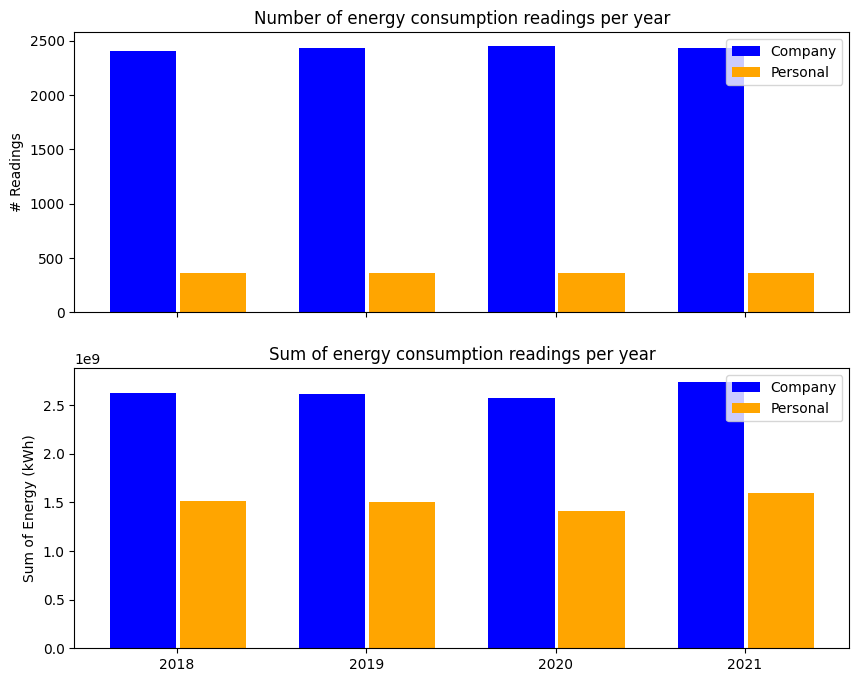

In [ ]:
# Number of energy readings per year person VS company
rol_contact_values = np.flip(sector_data['Personal/Company'].unique())
years = sector_data['Year'].unique()
count_data = sector_data.groupby(['Year', 'Personal/Company']).size().unstack()

# Plot the number of readings per year, companies vs people
fig, axes = plt.subplots(2, 1, figsize=(10, 8),sharex='all')
bar_width = 0.35
x = np.arange(len(years))
axes[0].bar(x, count_data['Bedrijf'].to_list() , width=bar_width, color='blue', label='Company')
axes[0].bar(x+bar_width+0.02, count_data['Persoon'].to_list() , width=bar_width, color='orange', label='Personal')
axes[0].set_title('Number of energy consumption readings per year')
axes[0].set_xticks(x + (bar_width+0.01) / 2)
axes[0].set_xticklabels(years)
axes[0].set_ylabel('# Readings')
axes[0].legend()

# Plot the sum of the energy readings per year, companies vs people
sum_data = sector_data.groupby(['Year', 'Personal/Company']).sum(numeric_only=True).unstack()
axes[1].bar(x, sum_data['AccessPoints*Consumption (kWh)']['Bedrijf'].to_list() , width=bar_width, color='blue', label='Company')
axes[1].bar(x+bar_width+0.02, sum_data['AccessPoints*Consumption (kWh)']['Persoon'].to_list() , width=bar_width, color='orange', label='Personal')
axes[1].set_title('Sum of energy consumption readings per year')
axes[1].set_xticks(x + (bar_width+0.01) / 2)
axes[1].set_xticklabels(years)
axes[1].set_ylabel('Sum of Energy (kWh)')
axes[1].legend()

plt.show()

On the top plot, the comparison between the number of registered readings between personal and company sources, where the former has around 6 times fewer readings. However, when comparing the actual power used from the grid, the personal readings exceed slightly more than 50% of the energy needed by companies. This shows that, on average, personal access points have a higher need for power, making it the ideal case for the application of alternative renewable sources of energy (like solar power).

####Energy Consumption per Month (1 year on 2020-2021)

The energy consumption per month constitutes important information to understand the consumption trends over time.

In [ ]:
# Load and preprocess data
path_month = os.path.join(data_path, 'energy_consumption_monthly.csv')
month_data = pd.read_csv(path_month, sep=';')
month_data = preprocess_energy_consumption_month(month_data)

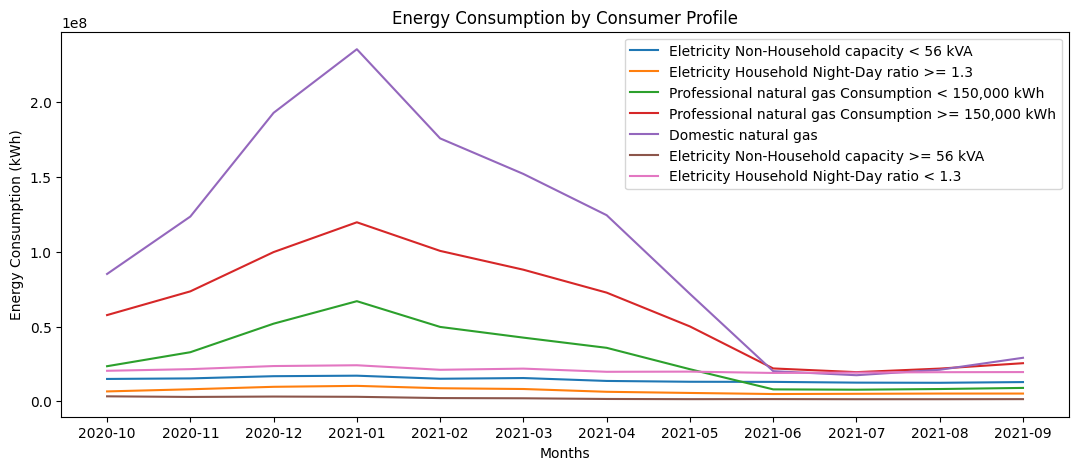

In [ ]:
# Plot the energy consumption by consumer profile
consumer_profiles = month_data['UserProfileCode'].to_list()
x_labels = np.flip(month_data.columns[3:15])
fig, ax = plt.subplots(figsize=(13,5))
# Plot a line for each consumer profile
for profile in consumer_profiles:
    # Get the energy consumption values for the current profile
    values = month_data.loc[month_data['UserProfileCode'] == profile, x_labels].values[0]
    # Plot the line with corresponding label
    ax.plot(x_labels, values, label=profile)
ax.set_xlabel('Months')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Energy Consumption by Consumer Profile')
ax.legend()
plt.show()

The line plot clearly shows a significant increase in energy usage during the winter and spring months. Notably, the three profiles that stand out prominently are all related to gas consumption. This observation suggests that gas was likely utilized for heating purposes, given the cold weather prevalent during these seasons in the northern region of Belgium, where Ghent is located.

####Energy Consumption per Street

The energy consumption per month constitutes important information to understand the consumption trends in specific locations of the city of Ghent. Out of the three datasets regarding energy consumption, this is the one which gives the most meaningful information for the creation of the energy community, as it is more detailed from a geographical perspective.

In [ ]:
# Load and preprocess the data
path_street = os.path.join(data_path, 'energy_consumption_street_level.csv')
street_data = pd.read_csv(path_street, sep=';')
street_data = preprocess_energy_consumption_streetEDA(street_data)

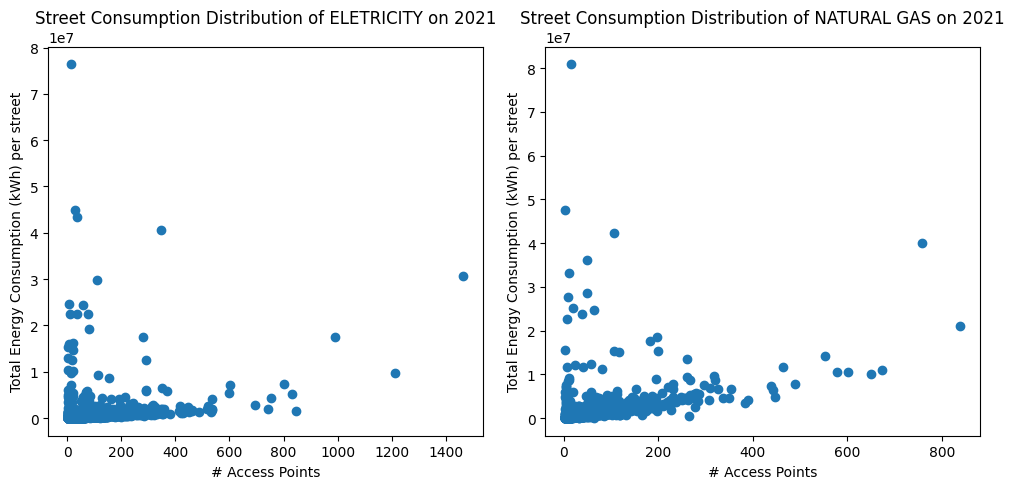

In [ ]:
# Split the DataFrame based on the 'Energy' column values
electricty_df = street_data[street_data['Energy'] == 'Elektriciteit']
gas_df = street_data[street_data['Energy'] == 'Aardgas']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for 'Elektriciteit'
axs[0].scatter(electricty_df['Access Points'], electricty_df['Energy Consumption (kWh)'])
axs[0].set_xlabel('# Access Points')
axs[0].set_ylabel('Total Energy Consumption (kWh) per street')
axs[0].set_title('Street Consumption Distribution of ELETRICITY on 2021')

# Scatter plot for 'Aardgas'
axs[1].scatter(gas_df['Access Points'], gas_df['Energy Consumption (kWh)'])
axs[1].set_xlabel('# Access Points')
axs[1].set_ylabel('Total Energy Consumption (kWh) per street')
axs[1].set_title('Street Consumption Distribution of NATURAL GAS on 2021')

plt.tight_layout()
plt.show()

When comparing the plots, each dot represents a street. We can verify that the behaviour/trend of energy consumption of natural gas and electricity is very similar, even though there are fewer access points per street of natural gas readings. The high density of points near the origin means that each street in Ghent does not have a lot of access points (houses or lamp posts), which means the Total Energy Consumption (kWh) per street is also lower. However, we can see a few streets that are exceptions, where a low number of access points leads to a high expenditure of energy, being one of the key features of what might be a good candidate for an energy community.

#### Rent Prices

Through rent prices, the financial capacities of the people living in a certain area can also be assessed as the rent price is an indication of the cost of living on that area. Along with the average income data, this can give meaningful information on poverty, one of the factors the energy community tries to act on.

In [ ]:
# Read the data
ghent_rent_prices_path = os.path.join(data_path, 'ghent_rent_prices.csv')
ghent_rent_prices_pd = pd.read_csv(ghent_rent_prices_path)

In [ ]:
# Visualize prices on the map
visualize_points(ghent_rent_prices_pd, 'price_main_value', lon='long', lat='lat')

By observing the map, it can be seen that most of the rent prices are between 500 € and 1500 €. The municipality of Ghent is the one that has the highest number of houses for rent of all the municipalities.

#### Energy Storage Systems

As the name states, this dataset gives information on the existing energy storage systems connected to the distribution network and contains the following attributes: online placement date, type of technology, capacity (kWh), power inverter (KVA), voltage level and internal ID.

In [ ]:
# Read and preprocess the data
data_ESS = pd.read_csv(os.path.join(data_path, 'energy_storage_systems.csv'), sep=';')
data_ESS = preprocess_energy_storage(data_ESS)

In [ ]:
# Create a table with the attributes 'Online placement date' , 'Voltage level'
# and the sum of the capacity resulted by the registers grouped by date and Voltage level.
data_grouped = data_ESS.groupby(['Online placement date', 'Voltage level']).agg(sum=('Capacity (kWh)', 'sum')).reset_index()

# Data where voltage level is equal to LS - low storage
data_LS = data_grouped[data_grouped['Voltage level'] == 'LS']
print('Low storage data:')
print(data_LS.count())

# Data where voltage level is equal to MS - medium storage
data_MS = data_grouped[data_grouped['Voltage level'] == 'MS']
print('\nMedium storage data:')
print(data_MS.count())

Low storage data:
Online placement date    47
Voltage level            47
sum                      47
dtype: int64

Medium storage data:
Online placement date    0
Voltage level            0
sum                      0
dtype: int64


From above we can observe that after preprocessing only low storage systems are available, as medium storage systems all had empty capacity values.

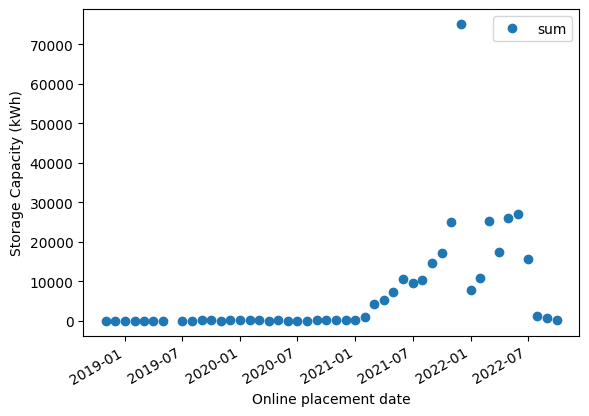

In [ ]:
ax = data_LS.plot(x='Online placement date', y='sum' , style='o')
ax.set_ylabel('Storage Capacity (kWh)');

Taking into account the graph which represents the storage capacity of LS systems over time. We verified that from 2019 to 2021 the capacity values were quite stable and from then on the storage capacity started to vary and increased significantly.

#### Energy Local Production

As the name indicates, this dataset gives information on the local energy production installations connected to the Fluvius network per municipality
and has the following attributes: reference date, DNB, main municipality, type of technology, number of local production and the installed power. All registers are from 2022.

In [ ]:
# Read and preprocess the data
data_loc_p = pd.read_csv(os.path.join(data_path, 'energy_local_production.csv'), sep=';')
data_gent = preprocess_energy_local_prod(data_loc_p)

In [ ]:
# Create a table with the attributes 'Reference date', 'Number of local production'
# and the sum of this number grouped by date.
data_number_local_production = data_gent[['Reference date', 'Number of local production']].groupby(['Reference date']).agg(sum=('Number of local production', 'sum'))
data_gent

index Reference date    DNB Main municipality   Type of technology  \
0    172     2022-10-01  IMEWO              GENT  BIOMASSA (GEEN WKK)   
1    173     2022-10-01  IMEWO              GENT    DIESEL (GEEN WKK)   
2    174     2022-10-01  IMEWO              GENT      NOODGROEP TYPE1   
3    175     2022-10-01  IMEWO              GENT      NOODGROEP TYPE2   
4    176     2022-10-01  IMEWO              GENT  WKK BIOMASSA/BIOGAS   
5    445     2022-10-01  IMEWO              GENT          WINDENERGIE   
6    446     2022-10-01  IMEWO              GENT          WKK AARDGAS   
7    766     2022-10-01  IMEWO              GENT         BRANDSTOFCEL   
8    767     2022-10-01  IMEWO              GENT        ZONNE-ENERGIE   

   Number of local production  Installed power  
0                           2         26644.00  
1                           5         10850.00  
2                           1           800.00  
3                          10         16350.00  
4                           4          1770.00  
5                          19         76754.00  
6                          34         60645.63  
7                           6            18.25  
8                       16738        117824.53

Analyzing the resulting table it is possible to see that not only all records are from the same date but also present the 'IMEWO' value for DNB.

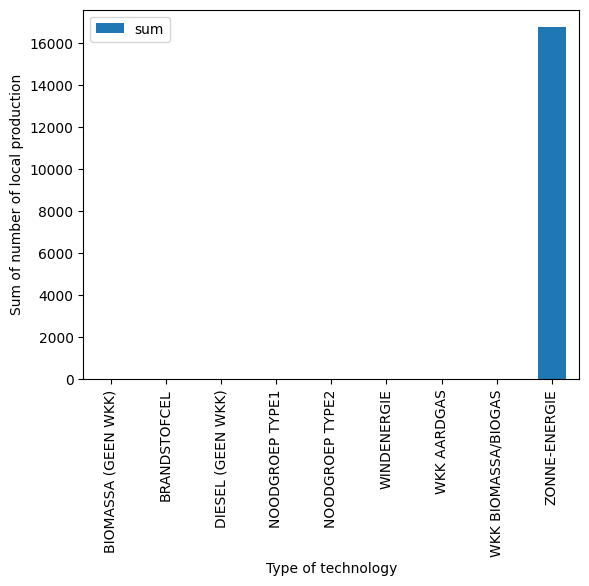

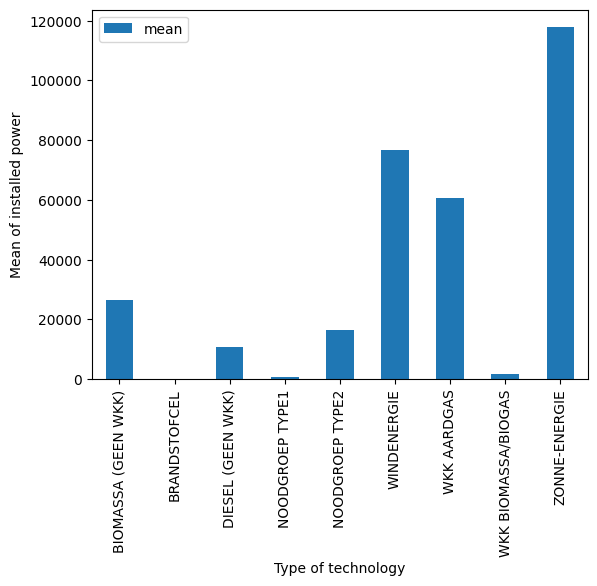

In [ ]:
# Create a table with the attributes 'Type of technology', 'Number of local production'
# and the sum of this number grouped by type of technology.
data_tech = data_gent[['Type of technology', 'Number of local production']].groupby(['Type of technology']).agg(sum=('Number of local production', 'sum'))
ax = data_tech.plot.bar()
ax.set_ylabel('Sum of number of local production');

# Create a table with the attributes 'Type of technology', 'Installed power'
# and the mean of this power grouped by type of technology.
data_tech_m = data_gent[['Type of technology', 'Installed power']].groupby(['Type of technology']).agg(mean=('Installed power', 'mean'))
ax = data_tech_m.plot.bar()
ax.set_ylabel('Mean of installed power');

The graphs above show that solar energy (in the graph as 'ZONNE-ENERGIE') has a number of production devices equal to 16738, out of 16819 in total, being by far the most used type of technology and also the one that has the highest mean of installed power.

#### Energy Decentral Production

As the name indicates, this dataset gives information on the decentral energy production connected to the distribution network and has the following attributes: year of commissioning, type of technology, power (KVA), voltage level, municipality, postal code and internal ID.

In [ ]:
# Read and preprocess dataset
data_dec_p = pd.read_csv(os.path.join(data_path, 'energy_decentral_production.csv'), sep=';')
data_gent_dec_P_final = preprocess_energy_decentral_prod(data_dec_p)

In [ ]:
# Plot average LS power produced
data_dec_ls = data_gent_dec_P_final[data_gent_dec_P_final['Voltage level']=='LS']
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=data_dec_ls, x='Year of commissioning', y='mean', hue='Postal code', palette='tab10')
ax.set_ylabel('Average Power (kVA)')
plt.title('LS Energy Decentralized Production');

# Plot average MS power produced
data_dec_ms = data_gent_dec_P_final[data_gent_dec_P_final['Voltage level']=='MS']
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=data_dec_ms, x='Year of commissioning', y='mean', hue='Postal code', palette='tab10')
ax.set_ylabel('Average Power (kVA)')
plt.title('MS Energy Decentralized Production');

The values for LS voltage level are much lower in comparison to those of MS. Besides that, the former present values that vary over the years but not in an abrupt way while the latter has clear peaks between 2008 and 2012 and also between 2018 and 2020.

Out of all the production/storage datasets, this one allows to better conjugate the information with the geographical data of Ghent.

#### Ghent Solar Load Output

This dataset contains geographical information on the city of Ghent: a 3D point cloud was taken from the city and the characteristics of its buildings were kept in order to assess the sun irradiation on each building.

In [ ]:
# Load shapefile data
gent_sol_path = os.path.join(data_path, 'pv_data', 'Gent_SOL_v3.shp')
gent_sol = gpd.read_file(gent_sol_path)

In [ ]:
# Pre-process data and exploration
gent_sol_filtered = preprocess_gent_sol(gent_sol)

# Extract latitude and longitude from the first point of each Polygon
gent_sol_filtered['latitude'] = gent_sol_filtered['geometry'].apply(lambda x: x.exterior.coords[0][1])
gent_sol_filtered['longitude'] = gent_sol_filtered['geometry'].apply(lambda x: x.exterior.coords[0][0])

print('Pre-processed data keys:', gent_sol_filtered.keys().to_list())

print('\nPre-processed dataset length:', len(gent_sol_filtered))

print('\nPre-processed number of null elements:')
for key in gent_sol_filtered.keys():
  num_null_elements = len(np.where(pd.isnull(gent_sol_filtered[key]))[0])
  if num_null_elements != 0:
    print(key, '-', num_null_elements)

Pre-processed data keys: ['building_id', 'object_id', 'building_type', 'building_type_encoded', 'building_category', 'date_creation', 'date_mapping', 'building_surface_area', 'building_length', 'streed_id', 'street_name', 'postal_code', 'building_number', 'SOL_OPP', 'SOL_OPP_3D', 'roof_slope', 'roof_orientation', 'ASI_sqm (W/m^2)', 'ASI_total (W/m^2)', 'roof_type', 'EEP (kWh)', 'geometry', 'latitude', 'longitude']

Pre-processed dataset length: 122965

Pre-processed number of null elements:


From the original data exploration, it was noted that there was a need to clarify each data key for a better understanding. It was also noted that 41336 data entries had no street name, NIS code, municipality or building number. These were filtered in the next cell by ensuring that all entries were from the city of Ghent. Above it can be verified that the problems were solved.

The data keys can be separated into three main categories:

* IDs and dates: IDs from the buildings/objects/streets and dates regarding creation and mapping. This information is of little importance, as it doesn't bring any value to determining the best energy communities.
* Building information: location and characteristics, which is of extreme importance as it influences its potential within an energy community.
* Energy-related fields: Solar Opportunity Area (SOL_OPP), Annual Solar Irradiation (ASI) and Estimated Energy Produced (EEP) by a solar installation or system, which are also of extreme importance since they were calculated already from the remaining characteristics to assess the potential of each building.

In [ ]:
# Check different between SOL_OPP with and without considering horizontal surfaces

diff = gent_sol_filtered['SOL_OPP_3D'] - gent_sol_filtered['SOL_OPP']
print('Average difference between SOL_OPP with and without considering horizontal surfaces:', np.mean(diff), '+/-', np.std(diff))

Average difference between SOL_OPP with and without considering horizontal surfaces: 6.136616110275281 +/- 11.61416190903214


Considering the range of the values for SOL_OPP observed in the graphs below, the difference is quite small.

In [ ]:
# Plot energy-related fields

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

gent_sol_filtered.plot('SOL_OPP_3D', legend=True, ax=axes[0, 0])
axes[0, 0].set_title('Solar Opportunity Area (considering horizontal surfaces)')

gent_sol_filtered.plot('EEP (kWh)', legend=True, ax=axes[0, 1])
axes[0, 1].set_title('Estimated Energy Produced (kWh)');

gent_sol_filtered.plot('ASI_sqm (W/m^2)', legend=True, ax=axes[1, 0])
axes[1, 0].set_title('Annual Solar Irradiation (per square meter) (W/m^2)')

gent_sol_filtered.plot('ASI_total (W/m^2)', legend=True, ax=axes[1, 1])
axes[1, 1].set_title('Annual Solar Irradiation (total) (W/m^2)');

It is possible to see above that the figures for SOL, ASI (total) and EEP have very similar distributions. In fact, these values are all calculations from the same features and intend to represent one similar thing: the potential of each building for solar energy production. In conclusion, there are some buildings that stand out as having clear potential for energy production within a community.

Below the same fields can be observed but plotted over the Ghent map.

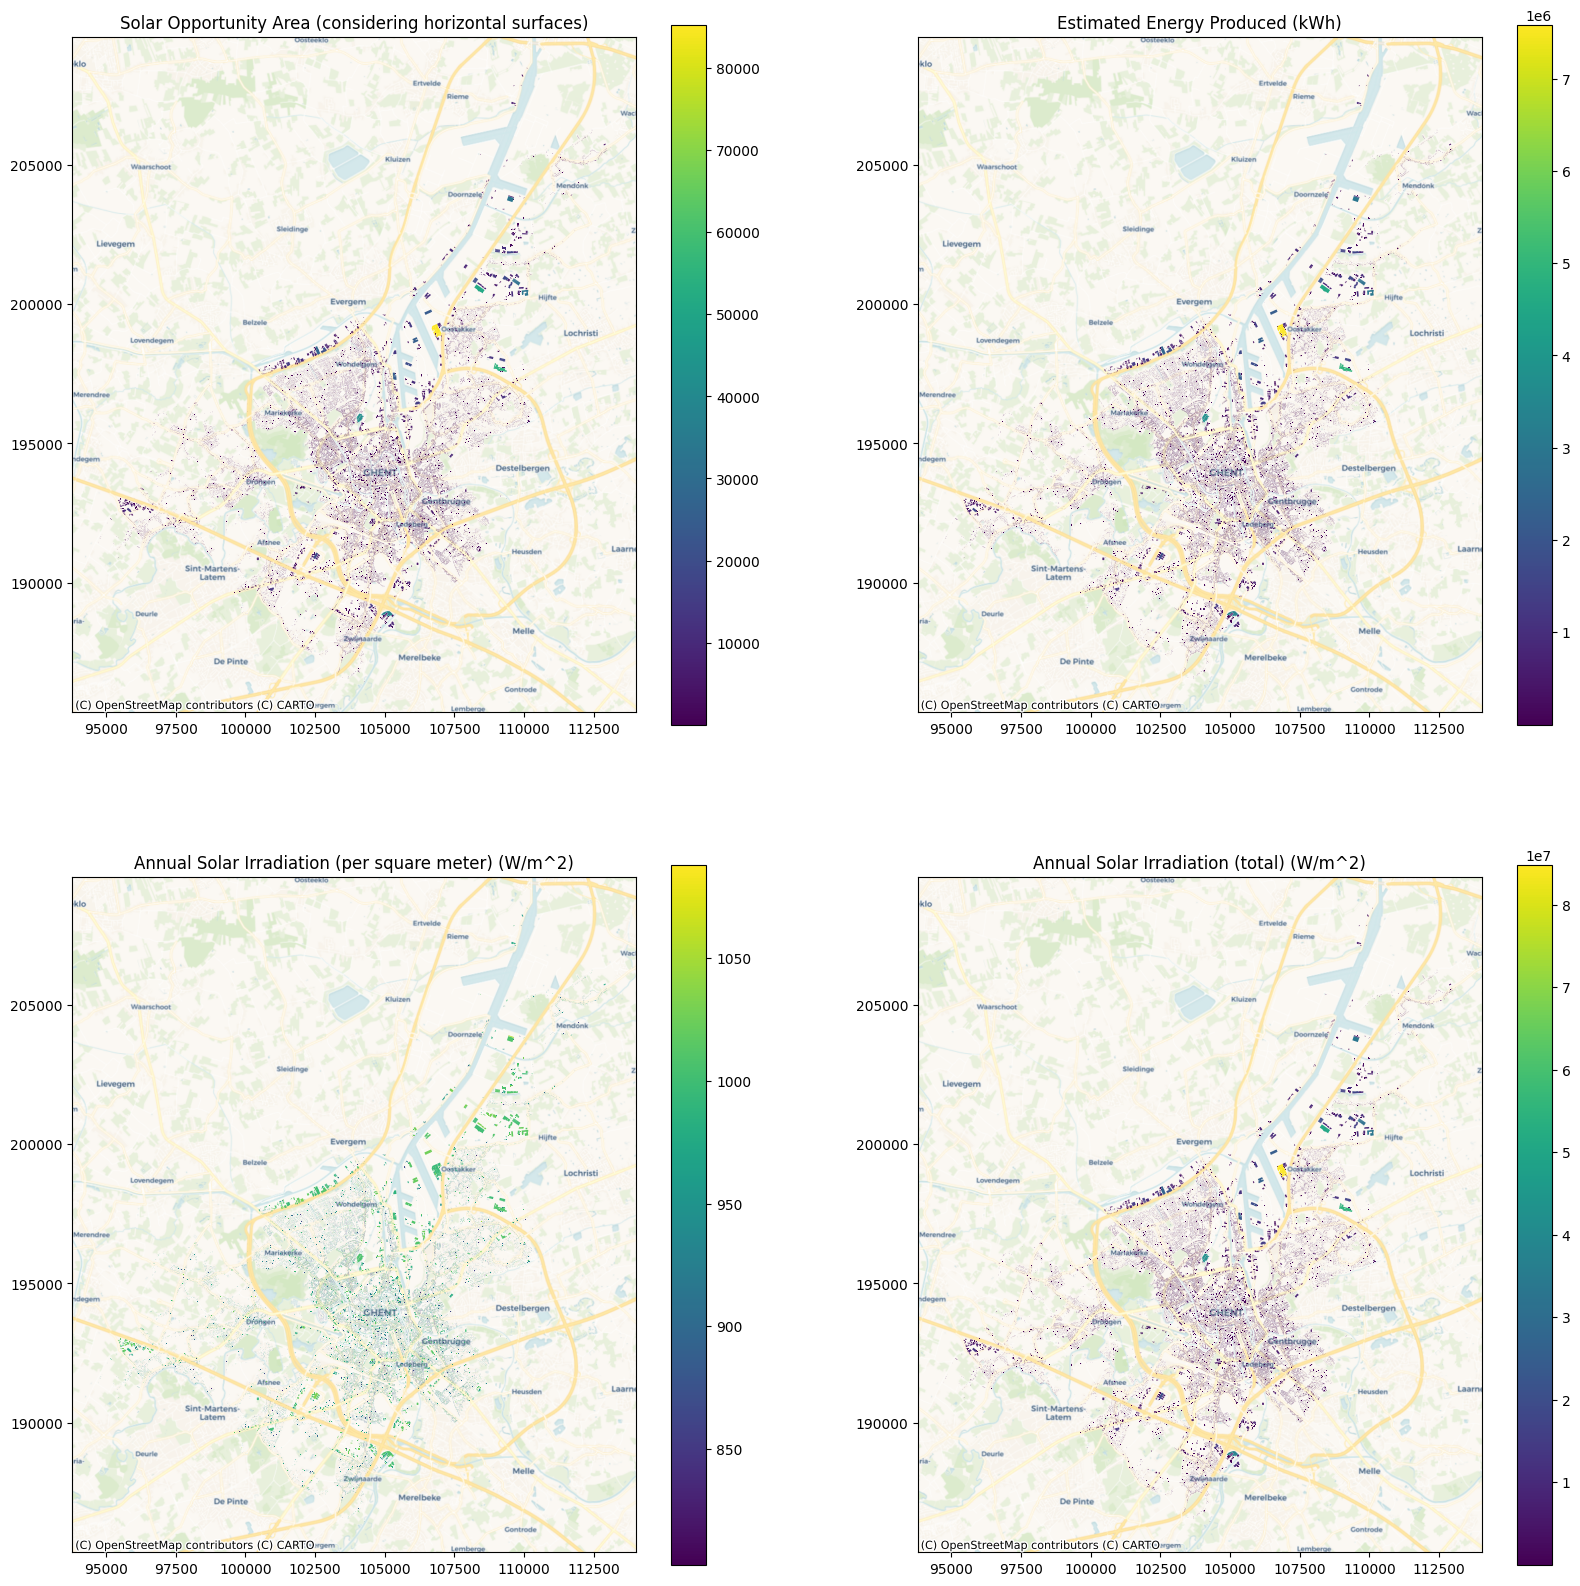

In [ ]:
# Plot energy-related fields on map

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

plot = gent_sol_filtered.plot('SOL_OPP_3D', legend=True, ax=axes[0, 0])
ctx.add_basemap(plot, crs=gent_sol_filtered.crs, source=ctx.providers.CartoDB.Voyager)
axes[0, 0].set_title('Solar Opportunity Area (considering horizontal surfaces)')

plot = gent_sol_filtered.plot('EEP (kWh)', legend=True, ax=axes[0, 1])
ctx.add_basemap(plot, crs=gent_sol_filtered.crs, source=ctx.providers.CartoDB.Voyager)
axes[0, 1].set_title('Estimated Energy Produced (kWh)');

plot = gent_sol_filtered.plot('ASI_sqm (W/m^2)', legend=True, ax=axes[1, 0])
ctx.add_basemap(plot, crs=gent_sol_filtered.crs, source=ctx.providers.CartoDB.Voyager)
axes[1, 0].set_title('Annual Solar Irradiation (per square meter) (W/m^2)')

plot = gent_sol_filtered.plot('ASI_total (W/m^2)', legend=True, ax=axes[1, 1])
ctx.add_basemap(plot, crs=gent_sol_filtered.crs, source=ctx.providers.CartoDB.Voyager)
axes[1, 1].set_title('Annual Solar Irradiation (total) (W/m^2)');

### Feature engineering

From the EDA it came that the Ghent Solar Load Output dataset is our main dataset as it contains the geographical information on the different city buildings. Therefore, this section intends to merge the possible remaining datasets into this one. The datasets that were not merged do not contain geographical information to do so.

#### Merge with the EV Charging Points dataset

In [ ]:
# Group EV points by postal code and calculate count and average power
ev_points_grouped = ev_points.groupby('Postal Code').agg({'Power (kVA)': ['count', 'mean']})

# Rename the columns
ev_points_grouped.columns = ['Charging Point Count', 'Average Power']

# Reset the index to make 'Postal Code' a regular column
ev_points_grouped = ev_points_grouped.reset_index()

# Merge the dataframes based on postal_code
gent_sol_eng1 = gent_sol_filtered.merge(ev_points_grouped, left_on='postal_code', right_on='Postal Code', how='left')

# Drop the redundant 'Postal Code' column
gent_sol_eng1 = gent_sol_eng1.drop('Postal Code', axis=1)

#### Merge with the Rent Prices dataset

In [ ]:
# Group by postal code and calculate count and average power
ghent_rent_prices_grouped = ghent_rent_prices_pd.groupby('postal_code').agg({'price_main_value': ['count', 'mean']})

# Rename the columns
ghent_rent_prices_grouped.columns = ['Houses for rent Count', 'Average Rent Price (€)']

# Reset the index to make 'postal_code' a regular column
ghent_rent_prices_grouped = ghent_rent_prices_grouped.reset_index()

ghent_rent_prices_grouped.rename(columns={'postal_code': 'postal_code2'}, inplace=True)

# Merge the dataframes based on postal_code
gent_sol_eng2 = gent_sol_eng1.merge(ghent_rent_prices_grouped, left_on='postal_code', right_on='postal_code2', how='left')

# Drop the redundant 'Postal Code' column
gent_sol_eng2 = gent_sol_eng2.drop('postal_code2', axis=1)

#### Merge with the Energy Decentral Production dataset

In [ ]:
# Combine Ghent SOL with the current dataset for auxiliary purposes
gent_sol_aux = gent_sol.groupby(['POSTCODE']).agg(count=('GRB_UIDN', 'count')).reset_index()
data_dec_P_final = data_gent_dec_P_final.merge(gent_sol_aux, left_on='Postal code', right_on='POSTCODE', how='left')

# Normalize the power by the number of surrounding buildings
data_dec_P_final['Power(kVA)'] = data_dec_P_final['mean'] / data_dec_P_final['count']

# Drop not needed features
data_dec_P_final = data_dec_P_final.drop(columns=['mean', 'count'])

# Get power value corresponding to the last year
data_dec_P_final = data_dec_P_final.groupby(['Postal code', 'Voltage level']).tail(1).drop(['Postal code', 'Year of commissioning'], axis=1)

# Merge the dataframes based on postal_code
gent_sol_eng3 = gent_sol_eng2.merge(data_dec_P_final, left_on='postal_code', right_on='POSTCODE', how='left')

####Merge with the Energy Consumption per Street

In [ ]:
# Get eletricity consumption by dividing the total consumption by the access points and filter the data
street_data['EletrictyConsumption'] = street_data['Energy Consumption (kWh)']/street_data['Access Points']
street_data_filtered = street_data.drop(columns=street_data.columns.difference(['street_name', 'EletrictyConsumption']))

# Merge the dataframes based on street_name
gent_sol_eng4 = gent_sol_eng3.merge(street_data_filtered, on='street_name', how='left')

#### Merge with Average Income

In [ ]:
# Get values to list
df_income = pd.DataFrame({'PostalCode': mean_income_values.index.tolist(),
                          'mean_income': mean_income_values['2019'].tolist(),
                          'std_income': std_income_values['2019'].tolist()})

# Merge the dataframes based on postal_code/PostalCode
gent_sol_eng5 = gent_sol_eng4.merge(df_income, left_on='postal_code', right_on='PostalCode',how='left' )

#### Get latitude and longitude

In [ ]:
# Extract latitude and longitude from the first point of each Polygon
gent_sol_eng6 = gent_sol_eng5.copy()
gent_sol_eng5['latitude'] = gent_sol_eng5['geometry'].apply(lambda x: x.exterior.coords[0][1])
gent_sol_eng5['longitude'] = gent_sol_eng5['geometry'].apply(lambda x: x.exterior.coords[0][0])

####Save merged dataset

In [ ]:
save_merged_path = os.path.join(data_path, 'others', 'Gent_SOL_Full_Merge_coord.csv')
merged_df = pd.DataFrame(gent_sol_eng5.drop(columns='geometry'))
merged_df.to_csv(save_merged_path,index=False)

### Models

#### Data preparation

Before feeding the data to the selected model, there was the need to perform some data preparation, specifically:
* Selecting the features of interest;
* Label encoding;
* Data normalization.

In [ ]:
# Read data that resulted from feature engineering
save_merged_path = os.path.join(data_path, 'others', 'Gent_SOL_Full_Merge_coord.csv')
model_data = pd.read_csv(save_merged_path)

In [ ]:
# Drop unecessary features: IDs, dates and street/posta
model_data.drop(['building_id', 'object_id', 'building_type','date_creation',
                 'date_mapping', 'street_name', 'streed_id', 'building_number',
                 'POSTCODE',  'PostalCode'],
                axis=1, inplace=True)

# Get spare energy variable - the difference between the estimated energy produced and the electricity consumption
model_data['Spare_Energy'] = model_data['EEP (kWh)']-model_data['EletrictyConsumption']
# Shift spare energy data to have only positive values, saving information on the minimum value
min_spare = -model_data['Spare_Energy'].min()
model_data['Spare_Energy'] = min_spare + model_data['Spare_Energy']
# Getting a threshold correspondent to 0 kWh when summing the spare energy of two buildings (used in custom distance function)
spare_thr_norm = (2*min_spare) / (model_data['Spare_Energy'].max())

# Encode necessary variables
model_data, encoded_dict = encode_features('roof_type', model_data)
model_data, encoded_dict_volt = encode_features('Voltage level', model_data)
model_data, encoded_dict_building = encode_features('building_category', model_data)

In [ ]:
# Normalizing the roof orientation feature, excluding the -9999 (value when it is unknown)

# Replace -9999 with NaN
df = model_data.copy()
df['roof_orientation'].replace(-9999, np.nan, inplace=True)

# Create a mask to exclude NaN values
mask = df['roof_orientation'].notnull()

# Extract the values to normalize
values_to_normalize = df.loc[mask, 'roof_orientation'].values.reshape(-1, 1)

# Perform normalization using StandardScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values_to_normalize)

# Replace the normalized values back into the DataFrame
df.loc[mask, 'roof_orientation'] = scaled_values.flatten()

# Replace NaN with -1
input_values = -1
df['roof_orientation'].fillna(input_values, inplace=True)

In [ ]:
# The rest of the features can be normalized without further processing

# Normalize all values except roof orientation
scaler_dataframe = MinMaxScaler()
model_data_normalized = scaler_dataframe.fit_transform(model_data.drop(['roof_orientation'], axis=1))

# Create a new DataFrame with the normalized values
df_normalized = pd.DataFrame(model_data_normalized, columns=model_data.columns.drop('roof_orientation'))

# Add the 'roof_orientation' column from the previous cell
df_normalized['roof_orientation'] = model_data['roof_orientation']
df_normalized['roof_orientation'] = df['roof_orientation'].tolist()

# Reorder the columns to match the original DataFrame
df_normalized = df_normalized[model_data.columns]

# Devide MS and LS power
df2 = df_normalized[df_normalized['Voltage level'] == 0.]
df2 = df2.reset_index(drop=True)
df_normalized = df_normalized[df_normalized['Voltage level'] == 1.]
df_normalized = df_normalized.reset_index(drop=True)
df_normalized['Power(kVA) MS'] = df2['Power(kVA)']
df_normalized = df_normalized.drop('Voltage level', axis=1)

In [ ]:
# Create a DataFrame with coordinates and social factors
df_social_factores = df_normalized.drop(['latitude', 'longitude', 'postal_code'], axis=1)
data = pd.DataFrame({'X': df_normalized['latitude'].values, 'Y': df_normalized['longitude'].values})
data = data.merge(df_social_factores, left_index=True, right_index=True)

# Drop NaN rows that would affect the computation of the score
dropped_rows = data[data.isna().any(axis=1)]
dropped_indexes = dropped_rows.index # The dropped indexes are saved so that the geometry can also be formatted to allow to show the result in a map
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)

####Model training

The methodology selected for this challenge was clustering by the K-means algorithm along with the Elbow method to find the optimal value for the number of clusters/communities, using the Within-Cluster Sum of Squares (WCSS) measure. Our technical advantage is that instead of a simple K-means optimized by euclidean distance, we developed a custom function to find the optimal community, by promoting geographical closeness while enhancing the diversity of energetic and financial conditions, key factors that define ideal energy communities as suggested in the sustainable developmment goals. Our solution is flexible to different goals, as the custom function is governed by weights that adapt the optimization of the arrangement of communities.

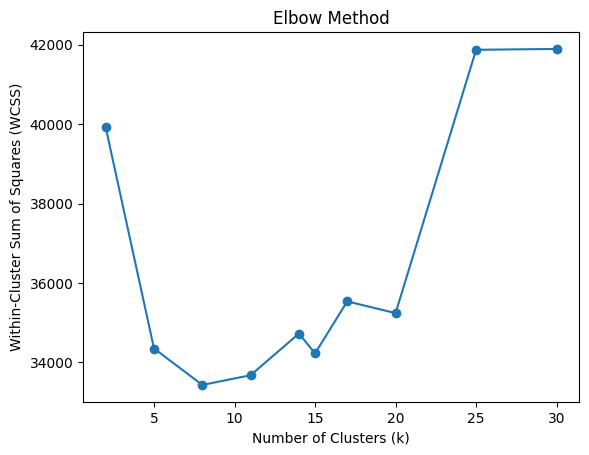

The ideal K is 8


In [ ]:
# Define the weights according to the importance given to each social aspect

geo_weight=0.4 # Adjust this value to control the importance of geographical closeness of the houses in the community
rent_diversity_weight = 0.05 # Adjust this value to control the importance of rent price diversity
income_diversity_weight = 0.05 # Adjust this value to control the importance of income diversity
EEP_diversity_weight = 0.3 # Adjust this value to control the importance of the diversity of Solar Output potential
consumption_diversity_weight = 0.15 # Adjust this value to control the importance of the diversity of eletricty comsunption
production_diversity_weight = 0.05 # Adjust this value to control the importance of the diversity of eletricty already produced
spare_reward_weight = 0.25 # Having spare energy when comparing 2 points rewards the score
alpha = 0.5 # Value to model the slope of inverse correlation between a feature and the score (higher diversity leads to a lower score)

# Testing of various values of K to calculate what is the ideal K based on the Within-Cluster Sum of Squares (WCSS)
# Running this optimization takes several hours, specially the higher the number of clusters. Since it would be interesting to have an optimization
# in the WebApp we suggest an alternative in the annex to do it.
kmin = 2
kmax = 31

ideal_k = model_k_optimization(kmin, kmax,np.asarray(data.copy()), geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight)

In [ ]:
# Define the number of communities you want to create - K (same number as the ideal_K)
num_communities = 8

user_function = lambda point1, point2: custom_distance(point1 , point2, geo_weight, rent_diversity_weight, income_diversity_weight, EEP_diversity_weight, consumption_diversity_weight, production_diversity_weight, spare_reward_weight)
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

features_list=np.asarray(data)

# create K-Means algorithm with specific distance metric
start_centers = kmeans_plusplus_initializer(features_list, num_communities).initialize()
kmeans_instance = kmeans(data, start_centers, metric=metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters() #
centers = kmeans_instance.get_centers()

# Create a DataFrame with house index and assigned community label
result = pd.DataFrame({'House': range(1, len(data)+1)})
result['Community'] = np.nan

# Assign community labels to each house
for community_label, cluster in enumerate(clusters):
    result.loc[cluster, 'Community'] = community_label + 1

# Print the assigned communities for each house
print(result)

         House  Community
0            1        6.0
1            2        8.0
2            3        3.0
3            4        3.0
4            5        6.0
...        ...        ...
120615  120616        5.0
120616  120617        5.0
120617  120618        5.0
120618  120619        5.0
120619  120620        5.0

[120620 rows x 2 columns]


####Visualization of communities on the map

After optimizing the K for a set of weights and running the clustering method according to the custom function, each building gets assigned to a specific community. To visualize that on the map, we fetch the geographical geometry data (not present on the training dataset) and combine it with the previous result to obtain the map of communities. As we are considering the entire city of Ghent, the communities formed host all of the houses, guiding the first step towards the enhancement of the sustainability the whole city energy grid.

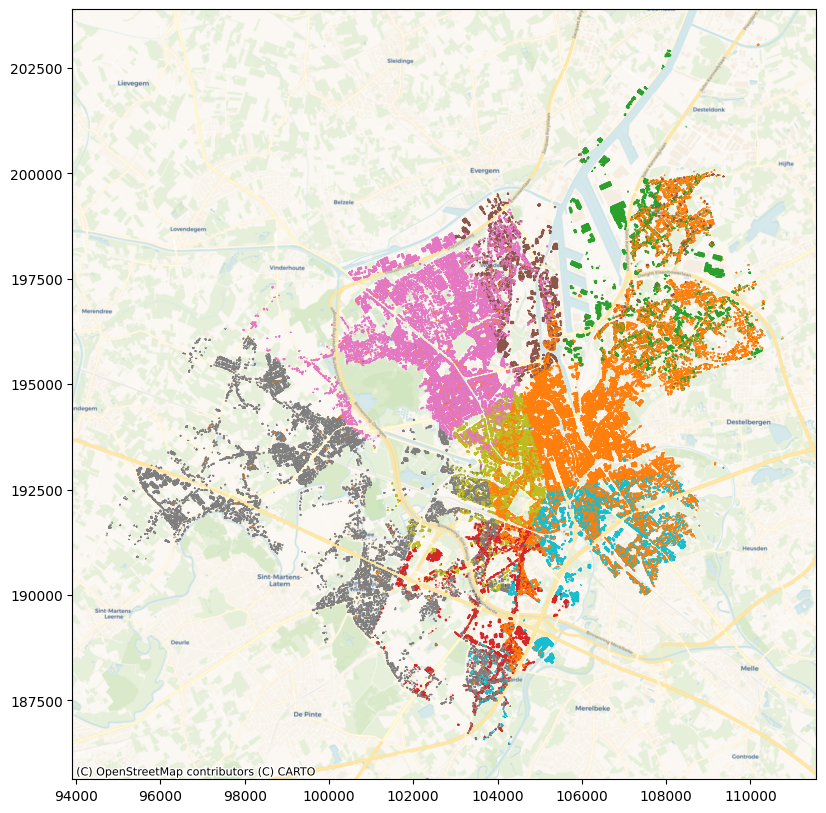

In [ ]:
# Filtering out the buildings that were previously dropped due to lack of some important feature that would affect the score.
gent_sol_filtered.drop(dropped_indexes,inplace=True)
gent_sol_filtered.reset_index(drop=True,inplace=True)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Get unique cluster labels
unique_labels = result['Community'].unique()

# Generate a color map based on the number of unique labels
color_map = plt.cm.get_cmap('tab10', len(unique_labels)+1)
color_values = np.linspace(0, 1, len(unique_labels)+1)

for polygon, label in zip(gent_sol_filtered['geometry'], result['Community']):

  # Create a matplotlib Polygon object from the polygon coordinates
  mpl_polygon = patches.Polygon(polygon.exterior.coords)

  # Get the color for the label from the color map
  color = color_map(color_values[int(label)])

  # Add the polygon to the axes with the corresponding color
  ax.add_patch(mpl_polygon)
  mpl_polygon.set_color(color)

# Set the aspect ratio and limits of the plot
ax.set_aspect('equal')
ax.autoscale()

# Add basemap
ctx.add_basemap(ax, crs=gent_sol_filtered.crs, source=ctx.providers.CartoDB.Voyager)

# Show the plot
plt.show()

The method implemented offers the great advantage of being easy to explain and to extract information from each cluster, so that we can have, for instance, a quick energy balance inside each cluster.

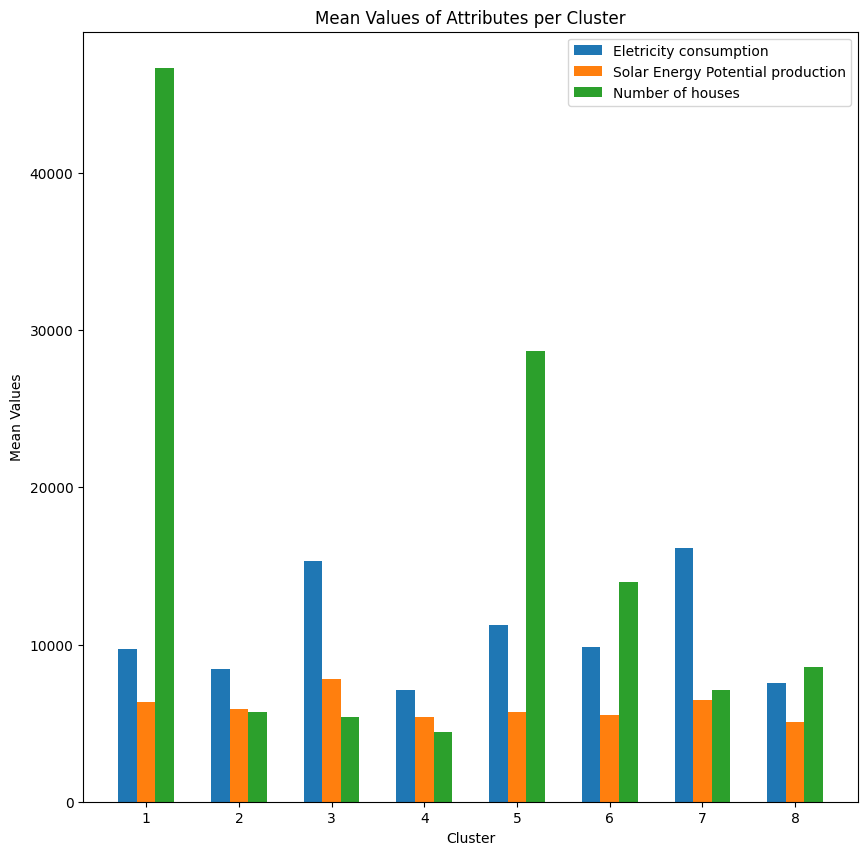

In [ ]:
# Function to create a plot that gives a notion about the number of buildings inside each cluster and the energy balance per house
# (consumption VS production)
cluster_info_explained(model_data, result)

This graph clearly illustrates that, in every cluster, the anticipated energy produced from new solar installations never exceeds the energy consumption per household, regardless of the number of houses. This favorable outcome demonstrates the efficient energy balance between houses with high solar exposure and buildings with high consumption, ensuring no energy is unnecessarily returned to the grid.

## 🖼️ Visualisations


As has been mentioned before, our solution gives the user the **flexibility to decide what is the importance of the key factors** that define society, when studying the **best energy community** for each city. We wanted to bring this product as close as possible to a published state, so that the variability of the weight given to each parameter feels real and the user can actually interact with them and see a change in the layout of the communities.
Therefore, **we developed a Web application** (WebApp) that allows the user to alter the weights as they see fit, as well as, define how many communities they would like to see in their city. For now, the website has the Ghent dataset preloaded so that you can directly **interact with it and compute a map** (depending on various factors the clustering needs time to achieve a good result, around an hour). After that the colored map is shown, as well as, a plot describing each cluster energy balance, taking advantage of the easy explainability from our solution.

Find the website here: [CEOS Energy Community Solution](https://livid-sour-leather.anvil.app/)

This site runs with support of the implementation which can be found at:
https://colab.research.google.com/drive/1su223LxDzYZIfFoNm4cJay9oyhEtZGnN?usp=sharing

Since is the first iteration of our web app for now, it is necessary to previously run the code present in this collab (each is a summarized version of the current submission notebook, with minor adaptations to run on the anvil). However, it will be possible to change it later (in an final version) so that this previous step is not necessary, becoming a "independent" plataform.



---



Please find in the following link a diagram that supports the **Executive Summary** > **Product** > **Activities** section: [https://drive.google.com/file/d/1rX4b_cOIb0EEeLExNZ-o0gYXCCuDJT3j/view?usp=sharing](https://)

## 👓 References

[1] "Global Energy Crisis" by International Energy Agency (IEA): https://www.iea.org/topics/global-energy-crisis?fbclid=IwAR2iOTL1Q-H_Wr-UAd6pTnj39XPE4yQwdJtyDSwD5zLSTgEy3RGIQujxfLg

[2] "Sustainable Development Goals" by United Nations Foundation: https://unfoundation.org/what-we-do/issues/sustainable-development-goals/?gclid=Cj0KCQjwnMWkBhDLARIsAHBOftrBIoURwQuDuq1a106h9mjSKauClGRdq5-nIYfCtZ0o0P_4JSibZPUaAgO5EALw_wcB&fbclid=IwAR3N5R3pAZZhsPTMSazPkQd_LuAjnzlR_-oEuROF8_3z1hQRXzbo-Fx0qD0

[3] "A new energy community to supply municipal and residential buildings in Poblenou" by infoBarcenlona: https://www.barcelona.cat/infobarcelona/en/tema/climate-emergency/a-new-energy-community-to-supply-municipal-and-residential-buildings-in-poblenou_1181683.html

[4] "Renewable energy district" by Department of Architecture of University of Bologna: https://projectgreta.eu/case-study/renewable-energy-district/


## ⏭️ Appendix


####Example of future APP code to find the most optimal K based on the input set of weights

Each set of weights have a correspondent ideal number of communities to be formed. However to compute that it takes a lot of time.

To solve this issue we can compute beforehand high number of different sets of weights and their ideal K based on the inflection point of the elbow plot, and save them in a dictionary.
This is a process that should be done everytime a new dataset is gathered, for a new city for example.

Based on this dictionary, everytime a new set of weights is given we can apply a K-NN algorthm with K=1 to verify which of the entries in the dictionary is more similar to the one inputted in the webapp, giving us a fast idea of what the ideal K is.

Due to time constraints, we could not build this dictionary. However, it shows how the webapp can be improved even further with an already thought solution, offering an easy and intelligent way to find the ideal K, instead of it being inputted by the user.

In [ ]:
# In this example of the method described before we use 3 combinations of ideal K and weights
ideak_K_dict = {  7 : [0.4,0.05,0.05,0.3,0.15,0.05,0.25], # our current solution
                 10 : [0.6,0.15,0.05,0.1,0.05,0.05,0.35], # mock-up idea
                 15 : [0.2,0.25,0.15,0.1,0.15,0.15,0.15] # continue on until reaching a high number of sets of ideal K: [weights]
                  }

def K_NN_1(input_dict, new_list):
    min_distance = float('inf')  # Initialize min_distance to "infinity"
    closest_key = None  # Initialize closest_key, i.e., the ideal K to None

    for key, value in input_dict.items():
        distance = np.linalg.norm(np.array(value) - np.array(new_list))
        if distance < min_distance:
            min_distance = distance
            closest_key = key

    return closest_key  # Return the ideal K of the most similar list

input_list= [0.3,0.2,0.25,0.0,0.1,0.15,0.45]
new_ideal_K = K_NN_1(ideak_K_dict, input_list)
print("Using the K-NN comparison algorithm the ideal K is "+ str(new_ideal_K))

Using the K-NN comparison algorithm the ideal K is 15
